In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cross_validation as skcv

In [188]:
tr_df = pd.read_csv('./simple_train.csv')
tst_df = pd.read_csv('./simple_test.csv')

In [189]:
# scale fs
m = max(max(tr_df.file_size.values),  max(tst_df.file_size.values))
tr_df.file_size = [float(x)/m for x in tr_df.file_size]
tst_df.file_size = [float(x)/m for x in tst_df.file_size]

In [190]:
def conv_df(df):
    d = df.as_matrix(columns=[
            'avg_0', 'avg_1', 'avg_2', 'avg_3', 'avg_4', 'avg_5', 'avg_6', 'avg_7',
            'avg_8', 'avg_9', 'avg_10', 'avg_11', 'avg_12', 'avg_13', 'avg_14', 'avg_15',
            'file_size'
    ])

    d = np.hstack((np.zeros([len(d), 3]), d))

    # vectorize patients
    for i in range(len(d)):
        p_ix = int(df.ix[i].patient_id - 1)
        d[i][p_ix] = 1.
        
    return np.array(d, dtype=np.float32)

In [191]:
X = conv_df(tr_df)
y = np.array([[x, 1. - x] for x in tr_df.result], dtype=np.float32)

In [192]:
X_eval = conv_df(tst_df)
files_eval = [str(x)[0] + '_' + str(int(str(x)[1:])) + '.mat'  for x in tst_df.Id]

In [193]:
X_train, X_test, y_train, y_test = \
    skcv.train_test_split(X, y, test_size=.2)

In [207]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard

In [214]:
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='tanh'))
model.add(Dense(2, activation='softmax'))

In [215]:
model.compile(loss='binary_crossentropy', optimizer='SGD')

In [217]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    nb_epoch=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=False,
    callbacks=[
#         keras.callbacks.ModelCheckpoint(
#             'out/models/j-e{epoch:02d}-l{loss:.5f}.hdf5', monitor='loss', verbose=1,
#             save_best_only=False, save_weights_only=False, mode='auto'),
        TensorBoard(log_dir='/tmp/tf-mls-4-b')
    ]
)

In [218]:
yp = model.predict(X_test)

In [219]:
yp

array([[ 0.06476003,  0.93523997],
       [ 0.08470138,  0.91529858],
       [ 0.06276607,  0.93723392],
       ..., 
       [ 0.06823567,  0.9317643 ],
       [ 0.07217414,  0.92782587],
       [ 0.07686706,  0.92313296]], dtype=float32)

(array([  11.,   86.,  160.,  261.,  366.,   92.,   49.,   32.,   30.,
          22.,   12.,    7.,    9.,   14.,   19.,   15.,   17.,    5.,
           0.,    2.]),
 array([ 0.01189387,  0.02425715,  0.03662044,  0.04898373,  0.06134701,
         0.0737103 ,  0.08607358,  0.09843687,  0.11080016,  0.12316344,
         0.13552673,  0.14789002,  0.1602533 ,  0.17261659,  0.18497988,
         0.19734316,  0.20970645,  0.22206974,  0.23443302,  0.24679631,
         0.25915959]),
 <a list of 20 Patch objects>)

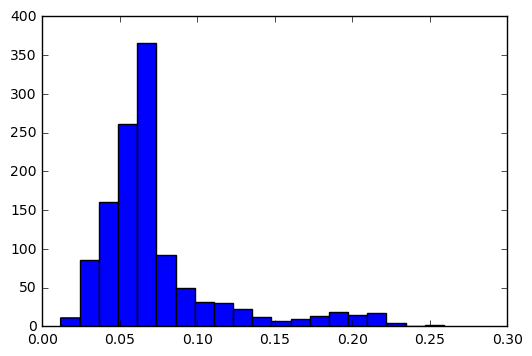

In [220]:
plt.hist(yp.T[0], bins=20)

In [221]:
y_eval = model.predict(X_eval, verbose=True)

6016/6126 [============================>.] - ETA: 0s

(array([  8.50000000e+01,   1.23500000e+03,   2.26700000e+03,
          1.14500000e+03,   3.78000000e+02,   1.99000000e+02,
          1.30000000e+02,   1.01000000e+02,   1.62000000e+02,
          1.38000000e+02,   1.40000000e+02,   9.30000000e+01,
          3.90000000e+01,   4.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([ 0.0056982 ,  0.02610194,  0.04650568,  0.06690942,  0.08731315,
         0.10771689,  0.12812063,  0.14852437,  0.16892811,  0.18933185,
         0.20973559,  0.23013932,  0.25054306,  0.2709468 ,  0.29135054,
         0.31175428,  0.33215802,  0.35256175,  0.37296549,  0.39336923,
         0.41377297]),
 <a list of 20 Patch objects>)

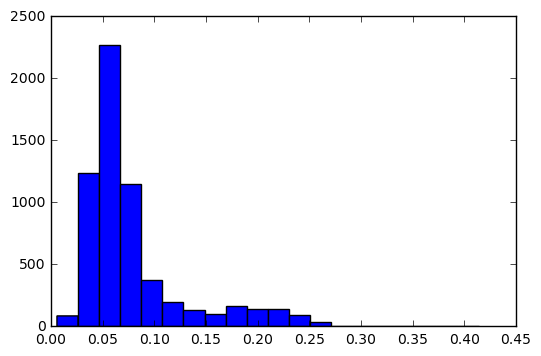

In [222]:
plt.hist(y_eval.T[0], bins=20)

In [226]:
res_df = pd.DataFrame({'File': files_eval, 'Class': y_eval.T[0]})

In [227]:
res_df.to_csv('subm-k.csv', index=False, columns=['File', 'Class'], float_format='%.8f')